In [1]:
pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 24.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing i

In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp

import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import MulticlassJaccardIndex, MulticlassAccuracy

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [24]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
        self.mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.long()

In [25]:
def get_transforms():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ElasticTransform(p=0.3),      
        A.GridDistortion(p=0.3),       
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])


train_dataset = SegmentationDataset(
    image_dir='/kaggle/input/spinach-leaf-area/spinach-leaf.v1i.png-mask-semantic/images/train',
    mask_dir='/kaggle/input/spinach-leaf-area/spinach-leaf.v1i.png-mask-semantic/masks/train',
    transform=get_transforms()
)

val_dataset = SegmentationDataset(
    image_dir='/kaggle/input/spinach-leaf-area/spinach-leaf.v1i.png-mask-semantic/images/val',
    mask_dir='/kaggle/input/spinach-leaf-area/spinach-leaf.v1i.png-mask-semantic/masks/val',
    transform=get_transforms()
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=4)

In [26]:
model = smp.DeepLabV3Plus(
    encoder_name="resnet101",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3
)
# model = nn.DataParallel(model)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
#############################################################
class_weights = torch.tensor([0.1, 1.0, 5.0]).to(device)

dice = smp.losses.DiceLoss(mode='multiclass', from_logits=True)
# focal = smp.losses.FocalLoss(mode='multiclass', ignore_index=0)
ce = nn.CrossEntropyLoss(weight=class_weights)

def combined_loss(pred, target):
    return 0.5 * dice(pred, target) + 0.5 * ce(pred, target)

#############################################################

criterion = combined_loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)

#############################################################


def train_model(model, loader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0
    for x, y in tqdm(loader, desc='\tTraining: '):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def eval_model(model, loader, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for x, y in tqdm(loader, desc='\tEvaluating: '):
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)

iou_metric = MulticlassJaccardIndex(num_classes=3).to(device)
acc_metric = MulticlassAccuracy(num_classes=3, average='weighted').to(device)

def evaluate_metrics(model, loader):
    model.eval()
    iou_metric.reset()
    acc_metric.reset()
    with torch.no_grad():
        for x, y in tqdm(loader, desc='\tEval metrics'):
            x, y = x.to(device), y.to(device)
            out = model(x)
            pred = torch.argmax(out, dim=1)
            iou_metric.update(pred, y)
            acc_metric.update(pred, y)
    iou = iou_metric.compute().cpu().numpy()
    acc = acc_metric.compute().item()
    return iou, acc

#############################################################

# 🔁 Training loop
for epoch in range(1, 21):
    print(f"[Epoch {epoch}]")
    train_loss = train_model(model, train_loader, criterion, optimizer, device)
    val_loss = eval_model(model, val_loader, criterion)
    train_iou, train_acc = evaluate_metrics(model, train_loader)
    val_iou, val_acc = evaluate_metrics(model, val_loader)
    print(f"\t-> Train Loss: {train_loss:.4f}, mIoU: {train_iou.mean():.4f}, Acc: {train_acc:.4f}")
    print(f"\t-> Val Loss: {val_loss:.4f}, mIoU: {val_iou.mean():.4f}, Acc: {val_acc:.4f}")
    print('#################################################################')

[Epoch 1]


	Eval metrics: 100%|██████████| 5/5 [00:00<00:00,  5.19it/s]


	-> Train Loss: 0.4778, mIoU: 0.6379, Acc: 0.9178
	-> Val Loss: 0.2879, mIoU: 0.6129, Acc: 0.9094
#################################################################
[Epoch 2]


	Eval metrics: 100%|██████████| 5/5 [00:00<00:00,  5.12it/s]


	-> Train Loss: 0.2974, mIoU: 0.7337, Acc: 0.9546
	-> Val Loss: 0.2410, mIoU: 0.7133, Acc: 0.9507
#################################################################
[Epoch 3]


	Eval metrics: 100%|██████████| 5/5 [00:00<00:00,  5.02it/s]


	-> Train Loss: 0.2326, mIoU: 0.8647, Acc: 0.9733
	-> Val Loss: 0.2051, mIoU: 0.8593, Acc: 0.9729
#################################################################
[Epoch 4]


	Eval metrics: 100%|██████████| 5/5 [00:00<00:00,  5.03it/s]


	-> Train Loss: 0.1538, mIoU: 0.9027, Acc: 0.9727
	-> Val Loss: 0.1069, mIoU: 0.9030, Acc: 0.9732
#################################################################
[Epoch 5]


	Eval metrics: 100%|██████████| 5/5 [00:00<00:00,  5.03it/s]


	-> Train Loss: 0.1012, mIoU: 0.9105, Acc: 0.9729
	-> Val Loss: 0.0746, mIoU: 0.9099, Acc: 0.9740
#################################################################
[Epoch 6]


	Eval metrics: 100%|██████████| 5/5 [00:00<00:00,  5.05it/s]


	-> Train Loss: 0.0765, mIoU: 0.9212, Acc: 0.9764
	-> Val Loss: 0.0601, mIoU: 0.9211, Acc: 0.9784
#################################################################
[Epoch 7]


	Eval metrics: 100%|██████████| 5/5 [00:00<00:00,  5.03it/s]


	-> Train Loss: 0.0645, mIoU: 0.9213, Acc: 0.9789
	-> Val Loss: 0.0498, mIoU: 0.9270, Acc: 0.9798
#################################################################
[Epoch 8]


	Eval metrics: 100%|██████████| 5/5 [00:01<00:00,  4.88it/s]


	-> Train Loss: 0.0567, mIoU: 0.9190, Acc: 0.9742
	-> Val Loss: 0.0454, mIoU: 0.9153, Acc: 0.9742
#################################################################
[Epoch 9]


	Eval metrics: 100%|██████████| 5/5 [00:00<00:00,  5.03it/s]


	-> Train Loss: 0.0556, mIoU: 0.8602, Acc: 0.9785
	-> Val Loss: 0.0774, mIoU: 0.8690, Acc: 0.9809
#################################################################
[Epoch 10]


	Eval metrics: 100%|██████████| 5/5 [00:01<00:00,  4.90it/s]


	-> Train Loss: 0.0629, mIoU: 0.9235, Acc: 0.9771
	-> Val Loss: 0.0361, mIoU: 0.9284, Acc: 0.9793
#################################################################
[Epoch 11]


	Eval metrics: 100%|██████████| 5/5 [00:01<00:00,  4.85it/s]


	-> Train Loss: 0.0486, mIoU: 0.9276, Acc: 0.9774
	-> Val Loss: 0.0372, mIoU: 0.9288, Acc: 0.9781
#################################################################
[Epoch 12]


	Eval metrics: 100%|██████████| 5/5 [00:01<00:00,  4.86it/s]


	-> Train Loss: 0.0456, mIoU: 0.9302, Acc: 0.9785
	-> Val Loss: 0.0332, mIoU: 0.9324, Acc: 0.9800
#################################################################
[Epoch 13]


	Eval metrics: 100%|██████████| 5/5 [00:01<00:00,  4.79it/s]


	-> Train Loss: 0.0455, mIoU: 0.9329, Acc: 0.9794
	-> Val Loss: 0.0323, mIoU: 0.9363, Acc: 0.9808
#################################################################
[Epoch 14]


	Eval metrics: 100%|██████████| 5/5 [00:00<00:00,  5.02it/s]


	-> Train Loss: 0.0450, mIoU: 0.9365, Acc: 0.9811
	-> Val Loss: 0.0325, mIoU: 0.9405, Acc: 0.9831
#################################################################
[Epoch 15]


	Eval metrics: 100%|██████████| 5/5 [00:01<00:00,  4.96it/s]


	-> Train Loss: 0.0416, mIoU: 0.9318, Acc: 0.9799
	-> Val Loss: 0.0320, mIoU: 0.9339, Acc: 0.9807
#################################################################
[Epoch 16]


	Eval metrics: 100%|██████████| 5/5 [00:01<00:00,  4.81it/s]


	-> Train Loss: 0.0459, mIoU: 0.9344, Acc: 0.9803
	-> Val Loss: 0.0322, mIoU: 0.9356, Acc: 0.9814
#################################################################
[Epoch 17]


	Eval metrics: 100%|██████████| 5/5 [00:01<00:00,  4.99it/s]


	-> Train Loss: 0.0441, mIoU: 0.9304, Acc: 0.9795
	-> Val Loss: 0.0316, mIoU: 0.9342, Acc: 0.9819
#################################################################
[Epoch 18]


	Eval metrics: 100%|██████████| 5/5 [00:01<00:00,  4.96it/s]


	-> Train Loss: 0.0410, mIoU: 0.9140, Acc: 0.9790
	-> Val Loss: 0.0334, mIoU: 0.9288, Acc: 0.9816
#################################################################
[Epoch 19]


	Eval metrics: 100%|██████████| 5/5 [00:01<00:00,  4.79it/s]


	-> Train Loss: 0.0397, mIoU: 0.9317, Acc: 0.9786
	-> Val Loss: 0.0296, mIoU: 0.9359, Acc: 0.9807
#################################################################
[Epoch 20]


	Eval metrics: 100%|██████████| 5/5 [00:01<00:00,  4.95it/s]

	-> Train Loss: 0.0395, mIoU: 0.9368, Acc: 0.9813
	-> Val Loss: 0.0304, mIoU: 0.9395, Acc: 0.9836
#################################################################


In [28]:
torch.save(model.state_dict(), 'best_model.pth')

(640, 640, 3)


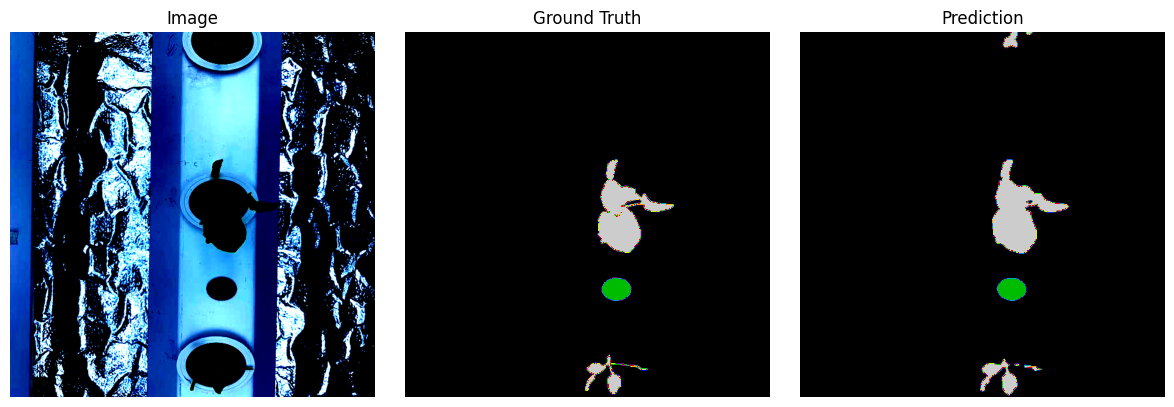

In [31]:
def visualize_prediction(model, dataset, idx=0):
    model.eval()
    image, true_mask = dataset[idx]
    with torch.no_grad():
        pred_mask = model(image.unsqueeze(0).to(device))
        pred_mask = torch.argmax(pred_mask.squeeze(), dim=0).cpu().numpy()

    image_np = image.permute(1, 2, 0).numpy()
    true_mask = true_mask.numpy()
    print(image_np.shape)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(image_np)
    axs[0].set_title("Image")
    axs[1].imshow(true_mask, cmap='nipy_spectral')
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pred_mask, cmap='nipy_spectral')
    axs[2].set_title("Prediction")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_prediction(model, val_dataset, idx=1)